# **CIFAR10 Dataset**

# **Settings**

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')                       # warning 출력 false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adam import Adam

from torchvision.datasets.cifar import CIFAR10
from torch.utils.data.dataloader import DataLoader

import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip

In [ ]:
%matplotlib inline
! pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


# ***! Note feature를 많이 뽑으면 좋을까? No***
* 과적합 발생할 수 있다.
* 시간이 너무 오래 걸린다.
* 역전파에 기울기 소실 가능성 있다.
* feature map이 무수히 많다는 건 결국 flatten과 같다.

## ***CNN 모델들***
* Lenet : kernel_size=5
* VGG : kernel_size=3
* ResNet : kernel_size=3, layer가 굉장히 많아짐
* Inception : kernel_size=3

# **1. 데이터 불러오기**

## **1) 데이터 살펴보기**

In [ ]:
# 데이터 전처리
train_data = CIFAR10(root='./', train=True, download=True, transform=T.ToTensor())
test_data = CIFAR10(root='./', train=False, download=True, transform=T.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


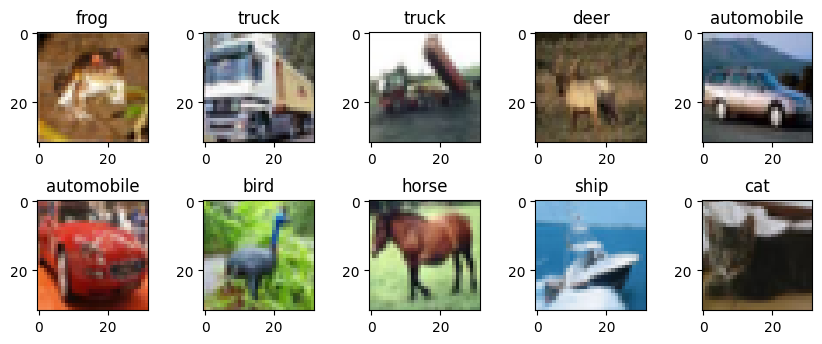

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

for i in range(10):
    idx = train_data.targets[i]
    ax = plt.subplot(2,5,i+1)
    ax.imshow(train_data.data[i])
    ax.set_title(train_data.classes[idx])

## ***! Note 데이터 증강(Data Augmentation)***
* 회전(rotation)
* 사이즈 변형(resize)
* 좌우, 상하 반전(flip)
* 이동
* 자르기(crop)

## ***! Note Random Seed 설정***

```
import torch

torch.manual_seed(100)
torch.cuda.manual_seed(100)         # cuda에서 random seed를 쓰면 속도 문제 발생
torch.cuda.manual_seed_all(100)     # 안 쓰는 것을 권장한다.

import numpy as np
np.random.seed(100)
```

## ***! Note 정규화가 필요한 이유?***
* 0~255 사이의 값. color마다의 영향이 차이가 크다.<br>
 color가 다른 것 뿐이지만 값이 큰 color가 영향을 더 많이 주게 된다.

In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
# RGB의 평균, 표준편차 구하기
images = []

for temp in train_data:
    images.append(temp[0])
images = torch.stack(images, dim=0).numpy()
print(images.shape)

mean_R = images[:,0,:,:].mean()
mean_G = images[:,1,:,:].mean()
mean_B = images[:,2,:,:].mean()
print(f'Mean : R {mean_R:.4f} G {mean_G:.4f} B {mean_B:.4f}')

std_R = images[:,0,:,:].std()
std_G = images[:,1,:,:].std()
std_B = images[:,2,:,:].std()
print(f'Std  : R {std_R:.3f}  G {std_G:.3f}  B {std_B:.3f}')

(50000, 3, 32, 32)
Mean : R 0.4914 G 0.4822 B 0.4465
Std  : R 0.247  G 0.243  B 0.262


In [ ]:
import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

# 데이터 전처리
data_transform = Compose(
    [
        T.ToPILImage(),
        RandomCrop((32,32),padding=4),
        RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.247,0.243,0.261)),
        T.ToPILImage()
    ]
)

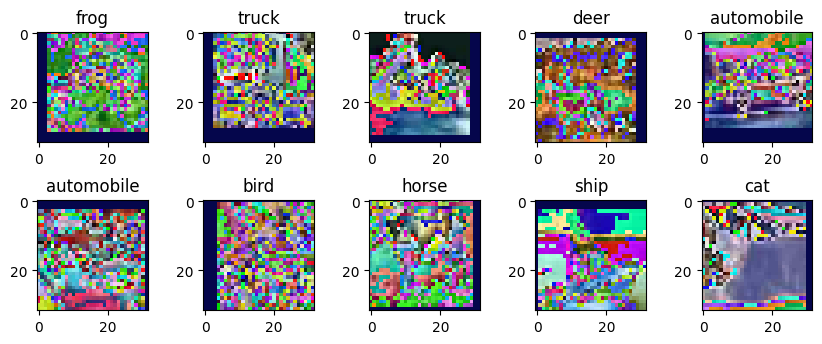

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

# seed 설정하기
torch.manual_seed(100)

for i in range(10):
    idx = train_data.targets[i]
    ax = plt.subplot(2,5,i+1)
    ax.imshow(data_transform(train_data.data[i]))
    ax.set_title(train_data.classes[idx])

## **2) 데이터 불러오기**

In [ ]:
data_transforms = Compose(
    [
        RandomCrop((32,32),padding=4),
        RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.247,0.243,0.261))
    ]
)

# 데이터 전처리
train_data = CIFAR10(root='./', train=True, download=True, transform=data_transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
data, label = next(iter(train_loader))
print(f'train_data = {data.shape}   label_data = {label.shape}')

train_data = torch.Size([32, 3, 32, 32])   label_data = torch.Size([32])


# **2. 모델 설정**

In [ ]:
# gpu 쓸 수 있는지 check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## **1) VGG16(비슷하게 구현)**

[[Kaggle] VGGNet-16 Architecture: A Complete Guide](https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide)

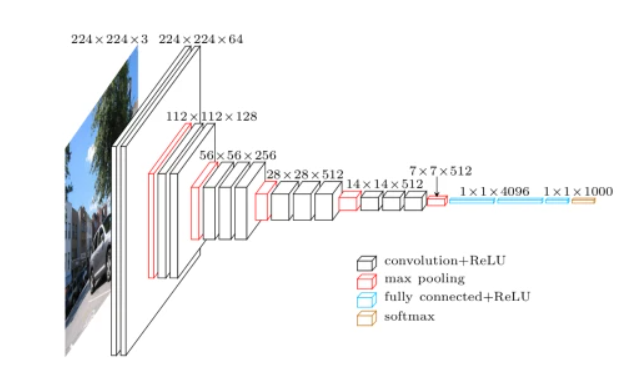

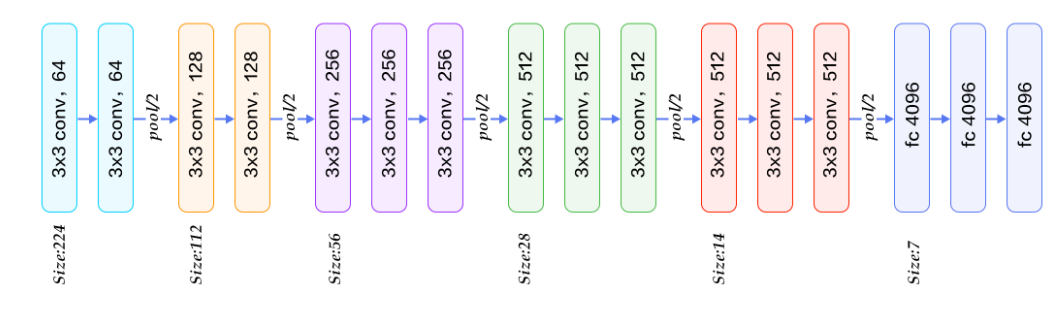

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        return x

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN,self).__init__()

        self.block1 = BasicBlock(in_channels=3,out_channels=32,hidden_dim=16)
        self.block2 = BasicBlock(in_channels=32,out_channels=128,hidden_dim=64)
        self.block3 = BasicBlock(in_channels=128,out_channels=256,hidden_dim=128)

        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x


## ***! Note 차원 직접 계산하기***
```
input 32 * 32 * 3

layer 1 (32 - 3 + 2) + 1 = 32 -> 32 * 32 *  16
layer 2 (32 - 3 + 2) + 1 = 32 -> 32 * 32 *  32
layer 3  32 / 2 = 16          -> 16 * 16 *  32

layer 1 (16 - 3 + 2) + 1 = 16 -> 16 * 16 *  32
layer 2 (16 - 3 + 2) + 1 = 16 -> 16 * 16 *  64
layer 3  16 / 2 = 8           ->  8 *  8 * 128

layer 1 ( 8 - 3 + 2) + 1 =  8 ->  8 *  8 * 128
layer 2 ( 8 - 3 + 2) + 1 =  8 ->  8 *  8 * 128
layer 3   8 / 4 = 2           ->  4 *  4 * 256

flatten 4 * 4 * 256 = 4096
```

In [ ]:
model = CNN(10)
model.to(device)

CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

# **3. 모델 학습**

In [ ]:
# 인스턴스 생성
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [ ]:
optim = Adam(model.parameters(), lr=1e-3)
epochs = 100

for epoch in range(epochs):
    for data, label in train_loader:
        optim.zero_grad()
        output = model(data.to(device))
        loss = nn.CrossEntropyLoss()(output, label.to(device))
        loss.backward()
        optim.step()

    print(f'epoch = {epoch + 1}, loss = {loss.item()}')
    writer.add_scalar('Loss/train', loss.item(), epochs+1)


In [ ]:
# 쓰기 종료
writer.close()

#코랩 안에서 띄우기위함
%load_ext tensorboard
#경로로 불러오기
%tensorboard --logdir=runs
# %tensorboard --logdir [경로] --port [포트번호]

# **4. 모델 예측**

In [ ]:
model.eval()

pred_list = []
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        _, pred = torch.max(preds.data, 1)
        pred_list.extend(pred)

        corr = pred.eq(labels).sum().item()
        total_corr += corr
        print(corr, end=' ')

    print()
    print(f'Accuracy = {total_corr / len(test_data)}')